In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
from diffusers import StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F

def set_seed(seed: int) -> torch.Generator:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    gen = torch.Generator(device='cuda')
    gen.manual_seed(seed)

    return gen


model_id = 'stabilityai/stable-diffusion-2-base'
device = 'cuda'
pipe = StableDiffusionPipeline.from_pretrained(model_id, use_auth_token=True)
pipe = pipe.to(device)


prompt = 'a football field'
# prompt = 'grassland'
seed = 241
steps = 30

with torch.cuda.amp.autocast(dtype=torch.float16), torch.no_grad():
    out = pipe(prompt, num_inference_steps=steps, generator=set_seed(seed))
    out.images[0].save('field.png')

/home/banyh2000/anaconda3/envs/daam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 30/30 [00:04<00:00,  6.67it/s]


In [2]:
def compute_loss(pipe, image, text, timesteps = None):
    '''ArithmeticError
    
    '''
    image = image.to(device)
    latents = pipe.vae.encode(image).latent_dist.sample()
    latents = latents * pipe.vae.config.scaling_factor
    noise = torch.randn_like(latents).to(device)
    if timesteps is None:
        timesteps = torch.randint(0, pipe.scheduler.config.num_train_timesteps, (1,), device=latents.device)
    timesteps = timesteps.to(device)
    timesteps = timesteps.long()
    # print("timesteps: ", timesteps)
    noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)
    text = pipe.tokenizer(
            text, max_length=pipe.tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )

    text = text.to(device)
    encoder_hidden_states = pipe.text_encoder(text.input_ids, return_dict=False)[0]
    if pipe.scheduler.config.prediction_type == "epsilon":
        target = noise
    elif pipe.scheduler.config.prediction_type == "v_prediction":
        target = pipe.scheduler.get_velocity(latents, noise, timesteps)
    else:
        raise ValueError(f"Unknown prediction type {pipe.scheduler.config.prediction_type}")

    model_pred = pipe.unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]
    loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
    
    return loss

In [3]:
def compute_loss_combo(pipe, image_1, image_2, theta, text, timesteps = None):
    '''ArithmeticError
    
    '''
    image_1 = image_1.to(device)
    image_2 = image_2.to(device)
    latents_1 = pipe.vae.encode(image_1).latent_dist.sample()
    latents_2 = pipe.vae.encode(image_2).latent_dist.sample()
    latents = theta * latents_1 + (1 - theta) * latents_2
    
    latents = latents * pipe.vae.config.scaling_factor
    noise = torch.randn_like(latents).to(device)
    if timesteps is None:
        timesteps = torch.randint(0, pipe.scheduler.config.num_train_timesteps, (1,), device=latents.device)
    timesteps = timesteps.to(device)
    timesteps = timesteps.long()
    # print("timesteps: ", timesteps)
    noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)
    text = pipe.tokenizer(
            text, max_length=pipe.tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )

    text = text.to(device)
    encoder_hidden_states = pipe.text_encoder(text.input_ids, return_dict=False)[0]
    if pipe.scheduler.config.prediction_type == "epsilon":
        target = noise
    elif pipe.scheduler.config.prediction_type == "v_prediction":
        target = pipe.scheduler.get_velocity(latents, noise, timesteps)
    else:
        raise ValueError(f"Unknown prediction type {pipe.scheduler.config.prediction_type}")

    model_pred = pipe.unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]
    loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
    
    return loss

In [4]:
def compute_loss_insert_noise(pipe, image, text, timesteps = None, noisepre_timesteps = None):
    '''ArithmeticError
    
    '''
    image = image.to(device)
    latents = pipe.vae.encode(image).latent_dist.sample()
    latents = latents * pipe.vae.config.scaling_factor
    
    noise_pre = torch.randn_like(latents).to(device)
    noisepre_timesteps = noisepre_timesteps.to(device)
    noisepre_timesteps = noisepre_timesteps.long()
    # print("timesteps: ", timesteps)
    latents = pipe.scheduler.add_noise(latents, noise_pre, noisepre_timesteps)
    
    
    noise = torch.randn_like(latents).to(device)
    if timesteps is None:
        timesteps = torch.randint(0, pipe.scheduler.config.num_train_timesteps, (1,), device=latents.device)
    timesteps = timesteps.to(device)
    timesteps = timesteps.long()
    # print("timesteps: ", timesteps)
    noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)
    
    
    text = pipe.tokenizer(
            text, max_length=pipe.tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )

    text = text.to(device)
    encoder_hidden_states = pipe.text_encoder(text.input_ids, return_dict=False)[0]
    if pipe.scheduler.config.prediction_type == "epsilon":
        target = noise
    elif pipe.scheduler.config.prediction_type == "v_prediction":
        target = pipe.scheduler.get_velocity(latents, noise, timesteps)
    else:
        raise ValueError(f"Unknown prediction type {pipe.scheduler.config.prediction_type}")

    model_pred = pipe.unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]
    loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
    
    return loss

In [5]:
def return_insert_noise(pipe, image, text, timesteps = None, noisepre_timesteps = None):
    '''ArithmeticError
    
    '''
    image = image.to(device)
    latents = pipe.vae.encode(image).latent_dist.sample()
    latents = latents * pipe.vae.config.scaling_factor
    
    noise_pre = torch.randn_like(latents).to(device)
    noisepre_timesteps = noisepre_timesteps.to(device)
    noisepre_timesteps = noisepre_timesteps.long()
    # print("timesteps: ", timesteps)
    latents = pipe.scheduler.add_noise(latents, noise_pre, noisepre_timesteps)
    
    return latents

In [8]:
def return_combo_latents(pipe, image_1, image_2, theta, text, timesteps = None):
    image_1 = image_1.to(device)
    image_2 = image_2.to(device)
    latents_1 = pipe.vae.encode(image_1).latent_dist.sample()
    latents_2 = pipe.vae.encode(image_2).latent_dist.sample()
    latents = theta * latents_1 + (1 - theta) * latents_2
    return latents

In [6]:
# read image from file and convert it to tensor
image_background = plt.imread('field.png')
image_background = torch.tensor(image_background, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
# normalize mean = 0.5, std = 0.5
image_background = (image_background - 0.5) / 0.5

image_object = plt.imread('football.png')
image_object = torch.tensor(image_object, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
image_object = (image_object - 0.5) / 0.5

# x = 200
# y = 400
# _, _, width, height = image_object.shape
# image_background = image_background[:,:,x:x+width,y:y+height]

print(image_background.shape)
print(image_object.shape)


torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


In [9]:
with torch.no_grad():
    loss = compute_loss(pipe, image_background, "   ", timesteps = torch.tensor([100]))
    print("loss: ", loss)

    loss = compute_loss_insert_noise(pipe, image_background, "   ", timesteps = torch.tensor([100]), noisepre_timesteps = torch.tensor([30]))
    print("loss: ", loss)
    latents = return_insert_noise(pipe, image_background, "   ", timesteps = torch.tensor([100]), noisepre_timesteps = torch.tensor([10]))
    image = pipe.decode_latents(latents)
    image = pipe.numpy_to_pil(image)[0]
    image.save('field_noise.png')


    loss = compute_loss(pipe, image_object, "   ", timesteps = torch.tensor([100]))
    print("loss: ", loss)

    loss = compute_loss_insert_noise(pipe, image_object, "   ", timesteps = torch.tensor([100]), noisepre_timesteps = torch.tensor([30]))
    print("loss: ", loss)
    latents = return_insert_noise(pipe, image_object, "   ", timesteps = torch.tensor([100]), noisepre_timesteps = torch.tensor([10]))
    image = pipe.decode_latents(latents)
    image = pipe.numpy_to_pil(image)[0]
    image.save('object_noise.png')

    # image = image_background * 0.5 + image_object * 0.5
    # loss = compute_loss(pipe, image, "   ", timesteps = torch.tensor([100]))

    loss = compute_loss_combo(pipe, image_background, image_object, 50/100, "   ", timesteps = torch.tensor([100]))

    print("loss: ", loss)
    latents = return_combo_latents(pipe, image_background, image_object, 50/100, "   ", timesteps = torch.tensor([100]))
    image = pipe.decode_latents(latents)
    image = pipe.numpy_to_pil(image)[0]
    image.save('combo.png')


loss:  tensor(0.3470, device='cuda:0')
loss:  tensor(0.4641, device='cuda:0')
loss:  tensor(0.3615, device='cuda:0')
loss:  tensor(0.4553, device='cuda:0')
loss:  tensor(0.4026, device='cuda:0')


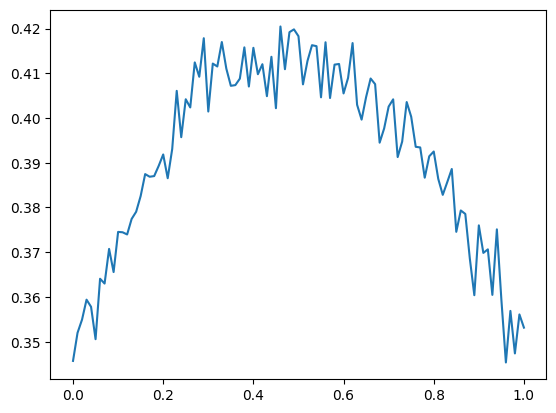

In [10]:
losses = []
for i in range(101):
    loss = compute_loss_combo(pipe, image_background, image_object, i/100, "   ", timesteps = torch.tensor([100]))
    losses.append(loss.item())
x = np.linspace(0, 1, 101)
plt.plot(x,losses)

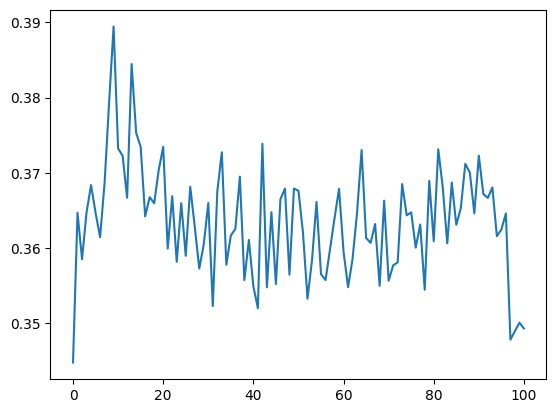

In [100]:
losses = []
for i in range(101):
    image = image_background * i / 100 + image_object * (100 - i) / 100
    image.to(device)
    loss = compute_loss(pipe, image, "   ", timesteps = torch.tensor([100]))
    losses.append(loss.item())
plt.plot(losses)

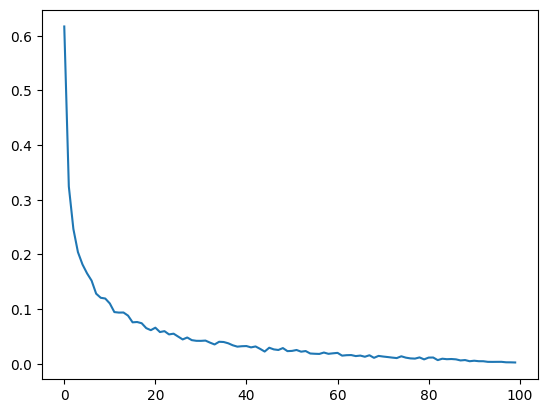

In [33]:
losses = []
for i in range(0, 1000,10):
    loss = compute_loss(pipe, image_object, prompt, timesteps=torch.tensor([i], device=device))
    losses.append(loss.item())
    
plt.plot(losses)

In [3]:
image = image_object.to(device)
latents = pipe.vae.encode(image).latent_dist.sample()
latents = latents * pipe.vae.config.scaling_factor
print(latents.shape)

torch.Size([1, 4, 64, 64])


In [104]:

noise = torch.randn_like(latents)
timesteps = torch.randint(0, pipe.scheduler.config.num_train_timesteps, (1,), device=latents.device)
timesteps = timesteps.long()
print(timesteps)
noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)

tensor([59], device='cuda:0')


In [5]:
text = 'a dog running across the street'
text = pipe.tokenizer(
            text, max_length=pipe.tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )

text = text.to(device)
encoder_hidden_states = pipe.text_encoder(text.input_ids, return_dict=False)[0]

In [8]:
if pipe.scheduler.config.prediction_type == "epsilon":
    target = noise
elif pipe.scheduler.config.prediction_type == "v_prediction":
    target = pipe.scheduler.get_velocity(latents, noise, timesteps)
else:
    raise ValueError(f"Unknown prediction type {pipe.scheduler.config.prediction_type}")

model_pred = pipe.unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]
loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

print(loss)

tensor(0.2809, device='cuda:0', grad_fn=<MseLossBackward0>)
